# Multi-Label WCP-L2D: Joint Conformal Prediction with Binary Classifiers

Combines the accuracy of per-pathology binary classifiers (AUC 0.82–0.90) with
graded deferral by running K=7 independent binary CPs and aggregating their
prediction sets into a joint deferral decision.

**Key question**: What replaces α? In standard CP, α controls single-label miscoverage.
For multi-label, we compare:
1. **Independent**: each binary CP at α, defer based on count of uncertain pathologies
2. **Bonferroni (FWER)**: each binary CP at α/K, guarantees P(any miscovered) ≤ α
3. **Max joint score**: single threshold on max per-pathology score
4. **Mean joint score**: single threshold on mean per-pathology score

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from wcp_l2d.features import ExtractedFeatures
from wcp_l2d.pathologies import COMMON_PATHOLOGIES, NUM_PATHOLOGIES
from wcp_l2d.label_utils import (
    extract_binary_labels,
    extract_multilabel_valid_samples,
    compute_pathology_prevalence,
)
from wcp_l2d.dre import AdaptiveDRE
from wcp_l2d.expert import SimulatedExpert
from wcp_l2d.multilabel_conformal import (
    MultilabelConformalPredictor,
    MultilabelWeightedConformalPredictor,
)
from wcp_l2d.multilabel_evaluation import (
    evaluate_multilabel_cp,
    evaluate_multilabel_wcp,
    evaluate_count_deferral,
    compute_multilabel_coverage,
    plot_multilabel_accuracy_rejection,
    plot_multilabel_coverage,
    plot_per_pathology_coverage_heatmap,
    multilabel_summary_table,
)

SEED = 42
K = NUM_PATHOLOGIES  # 7
EXPERT_ACCURACY = 0.85
FEATURE_DIR = Path("../../data/features")

np.random.seed(SEED)
torch.manual_seed(SEED)
print(f"K={K} pathologies: {COMMON_PATHOLOGIES}")

K=7 pathologies: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Pneumonia', 'Pneumothorax']


## 1. Load Features & NaN Analysis

In [2]:
# Load pre-extracted DenseNet121 features
chexpert = ExtractedFeatures.load(
    FEATURE_DIR / "chexpert_densenet121-res224-chex_features.npz"
)
nih = ExtractedFeatures.load(FEATURE_DIR / "nih_densenet121-res224-chex_features.npz")

print(f"CheXpert: {chexpert.features.shape}")
print(f"NIH:      {nih.features.shape}")

# NaN analysis per pathology
print("\nNaN rates per pathology:")
print(
    f"{'Pathology':<16} {'CheXpert NaN%':>14} {'NIH NaN%':>10} {'CheXpert valid':>16} {'NIH valid':>11}"
)
for i, p in enumerate(COMMON_PATHOLOGIES):
    chex_nan = np.isnan(chexpert.labels[:, i]).mean()
    nih_nan = np.isnan(nih.labels[:, i]).mean()
    chex_valid = (~np.isnan(chexpert.labels[:, i])).sum()
    nih_valid = (~np.isnan(nih.labels[:, i])).sum()
    print(
        f"{p:<16} {chex_nan:>13.1%} {nih_nan:>9.1%} {chex_valid:>16,} {nih_valid:>11,}"
    )

# Intersection sizes
for min_valid in [1, 3, 5, 7]:
    chex_valid = np.sum(np.sum(~np.isnan(chexpert.labels), axis=1) >= min_valid)
    nih_valid = np.sum(np.sum(~np.isnan(nih.labels), axis=1) >= min_valid)
    print(
        f"\nSamples with >= {min_valid} valid pathologies: CheXpert={chex_valid:,}, NIH={nih_valid:,}"
    )

CheXpert: (64534, 1024)
NIH:      (30805, 1024)

NaN rates per pathology:
Pathology         CheXpert NaN%   NIH NaN%   CheXpert valid   NIH valid
Atelectasis              58.1%      0.0%           27,008      30,805
Cardiomegaly             58.4%      0.0%           26,864      30,805
Consolidation            56.8%      0.0%           27,894      30,805
Edema                    44.9%      0.0%           35,544      30,805
Effusion                 31.6%      0.0%           44,140      30,805
Pneumonia                72.7%      0.0%           17,615      30,805
Pneumothorax             42.7%      0.0%           36,996      30,805

Samples with >= 1 valid pathologies: CheXpert=60,856, NIH=30,805

Samples with >= 3 valid pathologies: CheXpert=35,426, NIH=30,805

Samples with >= 5 valid pathologies: CheXpert=17,500, NIH=30,805

Samples with >= 7 valid pathologies: CheXpert=14,071, NIH=30,805


## 2. Data Splits

For the multi-label approach, we keep the original multi-label structure.
Each pathology's binary classifier trains on the subset of CheXpert samples
where that pathology has a non-NaN label.

In [3]:
# We need a consistent split across all pathologies.
# Split by sample index, then for each pathology filter NaN.
N_chex = len(chexpert.features)
N_nih = len(nih.features)

rng = np.random.RandomState(SEED)

# CheXpert: 60/20/20 split by index
chex_indices = np.arange(N_chex)
chex_train_idx, chex_tmp_idx = train_test_split(
    chex_indices, test_size=0.4, random_state=SEED
)
chex_cal_idx, chex_test_idx = train_test_split(
    chex_tmp_idx, test_size=0.5, random_state=SEED
)

# NIH: 50% unlabeled pool (all features for DRE) + 50% test
nih_all_perm = rng.permutation(N_nih)
nih_pool_feats_all = nih.features[nih_all_perm[: N_nih // 2]]

nih_test_idx = np.arange(N_nih)  # Use all NIH for test (multi-label)
# For a proper split, use half for test
nih_test_idx = nih_all_perm[N_nih // 2 :]

print(f"CheXpert train: {len(chex_train_idx)}")
print(f"CheXpert cal:   {len(chex_cal_idx)}")
print(f"CheXpert test:  {len(chex_test_idx)}")
print(f"NIH pool (DRE): {len(nih_pool_feats_all)}")
print(f"NIH test:       {len(nih_test_idx)}")

CheXpert train: 38720
CheXpert cal:   12907
CheXpert test:  12907
NIH pool (DRE): 15402
NIH test:       15403


## 3. Train 7 Binary Classifiers

In [4]:
# For each pathology: filter NaN from the split, train binary LR, get logits
scalers = {}
classifiers = {}
# Store per-pathology logits for cal and test sets
# We'll compute logits for ALL samples, then use the split indices
cal_logits_list = []  # K arrays of [N_cal, 2]
test_chex_logits_list = []  # K arrays of [N_chex_test, 2]
test_nih_logits_list = []  # K arrays of [N_nih_test, 2]

print(f"{'Pathology':<16} {'Train N':>8} {'Cal N':>7} {'CheX AUC':>9} {'NIH AUC':>8}")
print("-" * 55)

for k, pathology in enumerate(COMMON_PATHOLOGIES):
    # Get binary labels for this pathology across all CheXpert
    _, _, chex_valid_mask = extract_binary_labels(
        chexpert.features, chexpert.labels, COMMON_PATHOLOGIES, pathology
    )
    _, _, nih_valid_mask = extract_binary_labels(
        nih.features, nih.labels, COMMON_PATHOLOGIES, pathology
    )

    # Intersect with split indices
    train_mask = np.zeros(N_chex, dtype=bool)
    train_mask[chex_train_idx] = True
    train_valid = train_mask & chex_valid_mask

    cal_mask = np.zeros(N_chex, dtype=bool)
    cal_mask[chex_cal_idx] = True
    cal_valid = cal_mask & chex_valid_mask

    test_chex_mask = np.zeros(N_chex, dtype=bool)
    test_chex_mask[chex_test_idx] = True
    test_chex_valid = test_chex_mask & chex_valid_mask

    test_nih_mask = np.zeros(N_nih, dtype=bool)
    test_nih_mask[nih_test_idx] = True
    test_nih_valid = test_nih_mask & nih_valid_mask

    # Extract features and labels
    X_tr = chexpert.features[train_valid]
    y_tr = chexpert.labels[train_valid, k].astype(int)

    # Fit scaler and classifier
    sc = StandardScaler()
    X_tr_s = sc.fit_transform(X_tr)
    scalers[pathology] = sc

    clf = LogisticRegression(solver="lbfgs", max_iter=1000, C=1.0, random_state=SEED)
    clf.fit(X_tr_s, y_tr)
    classifiers[pathology] = clf

    # Evaluate on CheXpert test
    X_chex_te = sc.transform(chexpert.features[test_chex_valid])
    y_chex_te = chexpert.labels[test_chex_valid, k].astype(int)
    chex_auc = roc_auc_score(y_chex_te, clf.predict_proba(X_chex_te)[:, 1])

    # Evaluate on NIH test
    X_nih_te = sc.transform(nih.features[test_nih_valid])
    y_nih_te = nih.labels[test_nih_valid, k].astype(int)
    nih_auc = roc_auc_score(y_nih_te, clf.predict_proba(X_nih_te)[:, 1])

    print(
        f"{pathology:<16} {train_valid.sum():>8,} {cal_valid.sum():>7,} {chex_auc:>9.3f} {nih_auc:>8.3f}"
    )

Pathology         Train N   Cal N  CheX AUC  NIH AUC
-------------------------------------------------------
Atelectasis        16,172   5,450     0.788    0.678
Cardiomegaly       16,061   5,388     0.861    0.743
Consolidation      16,611   5,657     0.854    0.702
Edema              21,342   7,178     0.836    0.825
Effusion           26,419   8,815     0.874    0.821
Pneumonia          10,532   3,536     0.757    0.609
Pneumothorax       22,217   7,402     0.725    0.531


In [5]:
def get_binary_logits(clf, X):
    """Convert binary LR decision function to [N, 2] logits."""
    d = clf.decision_function(X)
    return np.column_stack([-d, d])


def compute_all_logits(features, indices, scalers, classifiers, pathologies):
    """Compute binary logits for all pathologies on a set of samples.

    Returns list of K arrays, each [N, 2], where N = len(indices).
    Note: logits are computed for ALL samples regardless of NaN labels.
    NaN handling happens at calibration time.
    """
    X = features[indices]
    logits_list = []
    for p in pathologies:
        X_s = scalers[p].transform(X)
        logits_list.append(get_binary_logits(classifiers[p], X_s))
    return logits_list


# Compute logits for cal and test sets
cal_logits_list = compute_all_logits(
    chexpert.features, chex_cal_idx, scalers, classifiers, COMMON_PATHOLOGIES
)
test_chex_logits_list = compute_all_logits(
    chexpert.features, chex_test_idx, scalers, classifiers, COMMON_PATHOLOGIES
)
test_nih_logits_list = compute_all_logits(
    nih.features, nih_test_idx, scalers, classifiers, COMMON_PATHOLOGIES
)

# Corresponding labels
cal_labels = chexpert.labels[chex_cal_idx]  # [N_cal, 7] with NaN
test_chex_labels = chexpert.labels[chex_test_idx]  # [N_test_chex, 7]
test_nih_labels = nih.labels[nih_test_idx]  # [N_test_nih, 7]

print(
    f"Cal logits: {len(cal_logits_list)} pathologies, each {cal_logits_list[0].shape}"
)
print(
    f"NIH test logits: {len(test_nih_logits_list)} pathologies, each {test_nih_logits_list[0].shape}"
)
print(
    f"Cal labels shape: {cal_labels.shape} (NaN count per pathology: {np.isnan(cal_labels).sum(axis=0)})"
)
print(
    f"NIH test labels shape: {test_nih_labels.shape} (NaN count per pathology: {np.isnan(test_nih_labels).sum(axis=0)})"
)

Cal logits: 7 pathologies, each (12907, 2)
NIH test logits: 7 pathologies, each (15403, 2)
Cal labels shape: (12907, 7) (NaN count per pathology: [7457 7519 7250 5729 4092 9371 5505])
NIH test labels shape: (15403, 7) (NaN count per pathology: [0 0 0 0 0 0 0])


## 4. DRE (Shared Across Pathologies)

In [6]:
# DRE with PCA(4) — same as binary/multiclass experiments
dre = AdaptiveDRE(n_components=4, weight_clip=20.0, random_state=SEED)
dre.fit(
    source_features=chexpert.features[chex_cal_idx],
    target_features=nih_pool_feats_all,
)

cal_weights = dre.compute_weights(chexpert.features[chex_cal_idx])
test_nih_weights = dre.compute_weights(nih.features[nih_test_idx])

diag = dre.diagnostics(chexpert.features[chex_cal_idx])
print("DRE Diagnostics:")
print(f"  Domain classifier AUC: {diag.domain_auc:.4f}")
print(f"  ESS: {diag.ess:.1f} / {len(cal_weights)} = {diag.ess_fraction:.3f}")
print(f"  Weights: mean={diag.weight_mean:.4f}, std={diag.weight_std:.4f}")
print(
    f"           min={diag.weight_min:.6f}, max={diag.weight_max:.4f}, median={diag.weight_median:.4f}"
)

DRE Diagnostics:
  Domain classifier AUC: 0.9622
  ESS: 826.5 / 12907 = 0.064
  Weights: mean=0.5909, std=2.2591
           min=0.000001, max=20.0000, median=0.0417


## 5. Independent Binary CPs (Baseline)

Run 7 independent binary CPs at α. Each pathology gets its own prediction set
over {0, 1}. Deferral is based on how many pathologies are uncertain (|C_k(x)| > 1).

In [7]:
alphas = np.array([0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50])

expert = SimulatedExpert(seed=SEED)

# Standard multi-label CP (independent)
indep_std_results = evaluate_multilabel_cp(
    cal_logits_list,
    cal_labels,
    test_nih_logits_list,
    test_nih_labels,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="independent",
    defer_threshold=1,
)

# In-domain verification
indep_std_chex_results = evaluate_multilabel_cp(
    cal_logits_list,
    cal_labels,
    test_chex_logits_list,
    test_chex_labels,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="independent",
    defer_threshold=1,
)

print("Independent Binary CP (NIH test):")
print(
    f"{'alpha':>6} {'Avg Cov':>8} {'Joint Cov':>10} {'Mean Unc':>9} {'Deferral':>9} {'Sys Acc':>8}"
)
for r in indep_std_results:
    print(
        f"{r.alpha_or_threshold:>6.2f} {r.average_label_coverage:>8.3f} {r.joint_coverage:>10.3f} "
        f"{r.mean_uncertain_pathologies:>9.2f} {r.deferral_rate:>9.3f} {r.system_accuracy:>8.3f}"
    )

Independent Binary CP (NIH test):
 alpha  Avg Cov  Joint Cov  Mean Unc  Deferral  Sys Acc
  0.01    0.997      0.982      6.72     1.000    0.864
  0.02    0.997      0.982      6.72     1.000    0.862
  0.05    0.997      0.982      6.72     1.000    0.863
  0.10    0.996      0.975      6.02     1.000    0.862
  0.15    0.967      0.789      4.32     1.000    0.862
  0.20    0.851      0.390      1.18     0.968    0.865
  0.30    0.627      0.097      0.00     0.000    0.924
  0.40    0.469      0.030      0.00     0.000    0.924
  0.50    0.352      0.009      0.00     0.000    0.924


In [8]:
# In-domain coverage verification
print("In-domain (CheXpert test) coverage verification:")
print(f"{'alpha':>6} {'Target':>7} {'Avg Cov':>8} {'Gap':>6} {'Joint Cov':>10}")
for r in indep_std_chex_results:
    target = 1 - r.alpha_or_threshold
    gap = r.average_label_coverage - target
    print(
        f"{r.alpha_or_threshold:>6.2f} {target:>7.2f} {r.average_label_coverage:>8.3f} {gap:>+6.3f} {r.joint_coverage:>10.3f}"
    )

In-domain (CheXpert test) coverage verification:
 alpha  Target  Avg Cov    Gap  Joint Cov
  0.01    0.99    0.992 +0.002      0.968
  0.02    0.98    0.992 +0.012      0.968
  0.05    0.95    0.992 +0.042      0.968
  0.10    0.90    0.980 +0.080      0.962
  0.15    0.85    0.937 +0.087      0.829
  0.20    0.80    0.825 +0.025      0.532
  0.30    0.70    0.698 -0.002      0.216
  0.40    0.60    0.598 -0.002      0.086
  0.50    0.50    0.499 -0.001      0.031


## 6. WCP Independent (DRE-Weighted)

In [9]:
# WCP with independent aggregation
indep_wcp_results = evaluate_multilabel_wcp(
    cal_logits_list,
    cal_labels,
    cal_weights,
    test_nih_logits_list,
    test_nih_labels,
    test_nih_weights,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="independent",
    defer_threshold=1,
)

print("WCP Independent (NIH test):")
print(
    f"{'alpha':>6} {'Avg Cov':>8} {'Joint Cov':>10} {'Mean Unc':>9} {'Deferral':>9} {'Sys Acc':>8}"
)
for r in indep_wcp_results:
    print(
        f"{r.alpha_or_threshold:>6.2f} {r.average_label_coverage:>8.3f} {r.joint_coverage:>10.3f} "
        f"{r.mean_uncertain_pathologies:>9.2f} {r.deferral_rate:>9.3f} {r.system_accuracy:>8.3f}"
    )

WCP Independent (NIH test):
 alpha  Avg Cov  Joint Cov  Mean Unc  Deferral  Sys Acc
  0.01    0.998      0.984      6.77     1.000    0.864
  0.02    0.997      0.982      6.72     1.000    0.863
  0.05    0.989      0.927      5.05     1.000    0.862
  0.10    0.949      0.704      3.83     1.000    0.862
  0.15    0.896      0.512      1.89     0.993    0.862
  0.20    0.817      0.326      0.21     0.208    0.909
  0.30    0.715      0.174      0.00     0.000    0.924
  0.40    0.611      0.088      0.00     0.000    0.924
  0.50    0.512      0.042      0.00     0.000    0.924


## 7. Bonferroni Correction (FWER Control)

In [10]:
# Bonferroni: run each binary CP at alpha/K
bonf_std_results = evaluate_multilabel_cp(
    cal_logits_list,
    cal_labels,
    test_nih_logits_list,
    test_nih_labels,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="bonferroni",
    defer_threshold=1,
)

bonf_wcp_results = evaluate_multilabel_wcp(
    cal_logits_list,
    cal_labels,
    cal_weights,
    test_nih_logits_list,
    test_nih_labels,
    test_nih_weights,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="bonferroni",
    defer_threshold=1,
)

# In-domain Bonferroni verification
bonf_std_chex_results = evaluate_multilabel_cp(
    cal_logits_list,
    cal_labels,
    test_chex_logits_list,
    test_chex_labels,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="bonferroni",
    defer_threshold=1,
)

print("Bonferroni (CheXpert test) — joint coverage should be >= 1-alpha:")
print(f"{'alpha':>6} {'Target':>7} {'Joint Cov':>10} {'Gap':>6}")
for r in bonf_std_chex_results:
    target = 1 - r.alpha_or_threshold
    gap = r.joint_coverage - target
    print(
        f"{r.alpha_or_threshold:>6.2f} {target:>7.2f} {r.joint_coverage:>10.3f} {gap:>+6.3f}"
    )

print("\nBonferroni (NIH test):")
print(f"{'alpha':>6} {'Avg Cov':>8} {'Joint Cov':>10} {'Deferral':>9} {'Sys Acc':>8}")
for r in bonf_std_results:
    print(
        f"{r.alpha_or_threshold:>6.2f} {r.average_label_coverage:>8.3f} {r.joint_coverage:>10.3f} "
        f"{r.deferral_rate:>9.3f} {r.system_accuracy:>8.3f}"
    )

Bonferroni (CheXpert test) — joint coverage should be >= 1-alpha:
 alpha  Target  Joint Cov    Gap
  0.01    0.99      1.000 +0.010
  0.02    0.98      1.000 +0.020
  0.05    0.95      0.982 +0.032
  0.10    0.90      0.968 +0.068
  0.15    0.85      0.968 +0.118
  0.20    0.80      0.968 +0.168
  0.30    0.70      0.968 +0.268
  0.40    0.60      0.968 +0.368
  0.50    0.50      0.968 +0.468

Bonferroni (NIH test):
 alpha  Avg Cov  Joint Cov  Deferral  Sys Acc
  0.01    1.000      1.000     1.000    0.863
  0.02    1.000      1.000     1.000    0.862
  0.05    0.999      0.991     1.000    0.862
  0.10    0.997      0.982     1.000    0.862
  0.15    0.997      0.982     1.000    0.863
  0.20    0.997      0.982     1.000    0.862
  0.30    0.997      0.982     1.000    0.864
  0.40    0.997      0.982     1.000    0.863
  0.50    0.997      0.982     1.000    0.862


## 8. Max Joint Score Aggregation

In [11]:
# Max joint score: s(x, y) = max_k s_k(x, y_k)
max_std_results = evaluate_multilabel_cp(
    cal_logits_list,
    cal_labels,
    test_nih_logits_list,
    test_nih_labels,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="max",
    defer_threshold=1,
)

max_wcp_results = evaluate_multilabel_wcp(
    cal_logits_list,
    cal_labels,
    cal_weights,
    test_nih_logits_list,
    test_nih_labels,
    test_nih_weights,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="max",
    defer_threshold=1,
)

# In-domain verification
max_std_chex_results = evaluate_multilabel_cp(
    cal_logits_list,
    cal_labels,
    test_chex_logits_list,
    test_chex_labels,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="max",
    defer_threshold=1,
)

print("Max Joint Score (NIH test):")
print(
    f"{'alpha':>6} {'Avg Cov':>8} {'Joint Cov':>10} {'Mean Unc':>9} {'Deferral':>9} {'Sys Acc':>8}"
)
for r_std, r_wcp in zip(max_std_results, max_wcp_results):
    print(
        f"Std: {r_std.alpha_or_threshold:>5.2f} {r_std.average_label_coverage:>8.3f} {r_std.joint_coverage:>10.3f} "
        f"{r_std.mean_uncertain_pathologies:>9.2f} {r_std.deferral_rate:>9.3f} {r_std.system_accuracy:>8.3f}"
    )
    print(
        f"WCP: {r_wcp.alpha_or_threshold:>5.2f} {r_wcp.average_label_coverage:>8.3f} {r_wcp.joint_coverage:>10.3f} "
        f"{r_wcp.mean_uncertain_pathologies:>9.2f} {r_wcp.deferral_rate:>9.3f} {r_wcp.system_accuracy:>8.3f}"
    )
    print()

Max Joint Score (NIH test):
 alpha  Avg Cov  Joint Cov  Mean Unc  Deferral  Sys Acc
Std:  0.01    1.000      1.000      7.00     1.000    0.862
WCP:  0.01    0.997      0.982      6.72     1.000    0.862

Std:  0.02    1.000      1.000      7.00     1.000    0.863
WCP:  0.02    0.997      0.982      6.72     1.000    0.864

Std:  0.05    0.997      0.982      6.72     1.000    0.864
WCP:  0.05    0.997      0.982      6.72     1.000    0.861

Std:  0.10    0.997      0.982      6.72     1.000    0.863
WCP:  0.10    0.997      0.982      6.72     1.000    0.864

Std:  0.15    0.997      0.982      6.72     1.000    0.864
WCP:  0.15    0.924      0.710      0.00     0.000    0.924

Std:  0.20    0.997      0.982      6.72     1.000    0.863
WCP:  0.20    0.918      0.679      0.00     0.000    0.924

Std:  0.30    0.997      0.982      6.72     1.000    0.862
WCP:  0.30    0.884      0.538      0.00     0.000    0.924

Std:  0.40    0.867      0.483      0.00     0.000    0.924
WCP:  0.4

## 9. Mean Joint Score Aggregation

In [12]:
# Mean joint score: s(x, y) = mean_k s_k(x, y_k)
mean_std_results = evaluate_multilabel_cp(
    cal_logits_list,
    cal_labels,
    test_nih_logits_list,
    test_nih_labels,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="mean",
    defer_threshold=1,
)

mean_wcp_results = evaluate_multilabel_wcp(
    cal_logits_list,
    cal_labels,
    cal_weights,
    test_nih_logits_list,
    test_nih_labels,
    test_nih_weights,
    alphas,
    COMMON_PATHOLOGIES,
    expert,
    aggregation="mean",
    defer_threshold=1,
)

print("Mean Joint Score (NIH test):")
print(
    f"{'alpha':>6} {'Avg Cov':>8} {'Joint Cov':>10} {'Mean Unc':>9} {'Deferral':>9} {'Sys Acc':>8}"
)
for r_std, r_wcp in zip(mean_std_results, mean_wcp_results):
    print(
        f"Std: {r_std.alpha_or_threshold:>5.2f} {r_std.average_label_coverage:>8.3f} {r_std.joint_coverage:>10.3f} "
        f"{r_std.mean_uncertain_pathologies:>9.2f} {r_std.deferral_rate:>9.3f} {r_std.system_accuracy:>8.3f}"
    )
    print(
        f"WCP: {r_wcp.alpha_or_threshold:>5.2f} {r_wcp.average_label_coverage:>8.3f} {r_wcp.joint_coverage:>10.3f} "
        f"{r_wcp.mean_uncertain_pathologies:>9.2f} {r_wcp.deferral_rate:>9.3f} {r_wcp.system_accuracy:>8.3f}"
    )
    print()

Mean Joint Score (NIH test):
 alpha  Avg Cov  Joint Cov  Mean Unc  Deferral  Sys Acc
Std:  0.01    0.924      0.710      0.00     0.000    0.924
WCP:  0.01    0.924      0.710      0.00     0.000    0.924

Std:  0.02    0.924      0.710      0.00     0.000    0.924
WCP:  0.02    0.924      0.710      0.00     0.000    0.924

Std:  0.05    0.924      0.710      0.00     0.000    0.924
WCP:  0.05    0.924      0.710      0.00     0.000    0.924

Std:  0.10    0.924      0.710      0.00     0.000    0.924
WCP:  0.10    0.740      0.205      0.00     0.000    0.924

Std:  0.15    0.617      0.080      0.00     0.000    0.924
WCP:  0.15    0.677      0.131      0.00     0.000    0.924

Std:  0.20    0.536      0.038      0.00     0.000    0.924
WCP:  0.20    0.597      0.065      0.00     0.000    0.924

Std:  0.30    0.410      0.009      0.00     0.000    0.924
WCP:  0.30    0.474      0.019      0.00     0.000    0.924

Std:  0.40    0.330      0.004      0.00     0.000    0.924
WCP:  0.

## 10. Count-Based Deferral Sweep

Fix α and sweep the deferral threshold τ: defer if ≥τ pathologies are uncertain.
This decouples coverage control from deferral granularity.

In [13]:
alpha_fixed = 0.1

# Generate prediction sets at fixed alpha using independent CP
cp_fixed = MultilabelConformalPredictor(n_pathologies=K, penalty=0.1, kreg=1)
cp_fixed.calibrate(
    cal_logits_list, cal_labels, alpha=alpha_fixed, aggregation="independent"
)
pred_sets_std, set_sizes_std = cp_fixed.predict(
    test_nih_logits_list, aggregation="independent"
)

# WCP prediction sets
wcp_fixed = MultilabelWeightedConformalPredictor(n_pathologies=K, penalty=0.1, kreg=1)
wcp_fixed.calibrate(cal_logits_list, cal_labels, cal_weights, aggregation="independent")
pred_sets_wcp, set_sizes_wcp = wcp_fixed.predict(
    test_nih_logits_list, test_nih_weights, alpha=alpha_fixed, aggregation="independent"
)

# Count-based deferral sweep
count_std_results = evaluate_count_deferral(
    pred_sets_std,
    test_nih_logits_list,
    test_nih_labels,
    COMMON_PATHOLOGIES,
    expert,
    method_name=f"Std CP (alpha={alpha_fixed})",
    alpha=alpha_fixed,
)

count_wcp_results = evaluate_count_deferral(
    pred_sets_wcp,
    test_nih_logits_list,
    test_nih_labels,
    COMMON_PATHOLOGIES,
    expert,
    method_name=f"WCP (alpha={alpha_fixed})",
    alpha=alpha_fixed,
)

print(f"Count-based deferral sweep at alpha={alpha_fixed} (NIH test):")
print(
    f"{'tau':>4} {'Std Defer':>10} {'Std Sys Acc':>12} {'WCP Defer':>10} {'WCP Sys Acc':>12}"
)
for r_std, r_wcp in zip(count_std_results, count_wcp_results):
    print(
        f"{int(r_std.alpha_or_threshold):>4} {r_std.deferral_rate:>10.3f} {r_std.system_accuracy:>12.3f} "
        f"{r_wcp.deferral_rate:>10.3f} {r_wcp.system_accuracy:>12.3f}"
    )

Count-based deferral sweep at alpha=0.1 (NIH test):
 tau  Std Defer  Std Sys Acc  WCP Defer  WCP Sys Acc
   0      1.000        0.863      1.000        0.862
   1      1.000        0.862      1.000        0.865
   2      1.000        0.864      1.000        0.861
   3      1.000        0.862      0.991        0.862
   4      0.999        0.863      0.842        0.873
   5      0.984        0.863      0.000        0.924
   6      0.837        0.871      0.000        0.924
   7      0.205        0.911      0.000        0.924
   8      0.000        0.924      0.000        0.924


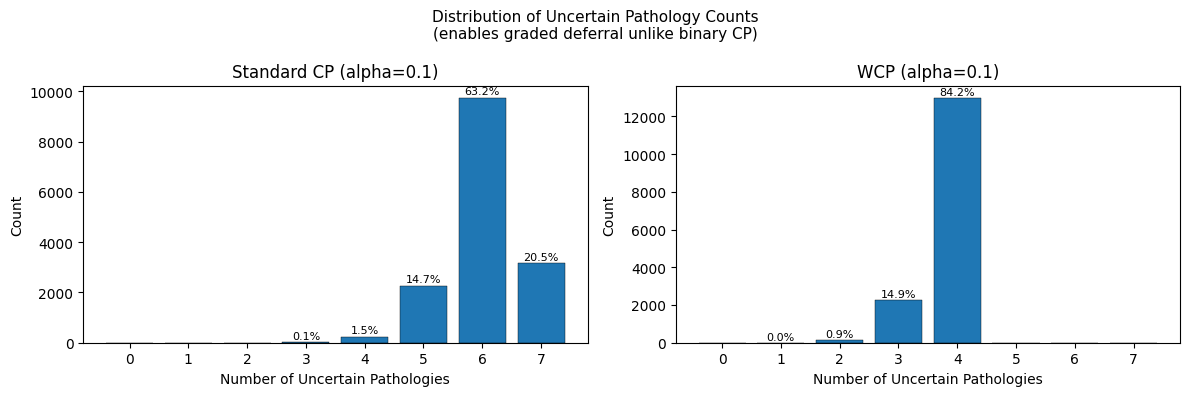

In [14]:
# Distribution of uncertain pathology counts
uncertain_std = (set_sizes_std > 1).sum(axis=1)
uncertain_wcp = (set_sizes_wcp > 1).sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, unc, title in [
    (axes[0], uncertain_std, f"Standard CP (alpha={alpha_fixed})"),
    (axes[1], uncertain_wcp, f"WCP (alpha={alpha_fixed})"),
]:
    counts = np.bincount(unc, minlength=K + 1)
    ax.bar(range(K + 1), counts, edgecolor="black", linewidth=0.3)
    ax.set_xlabel("Number of Uncertain Pathologies")
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.set_xticks(range(K + 1))
    for i, c in enumerate(counts):
        if c > 0:
            ax.text(
                i,
                c + len(uncertain_std) * 0.01,
                f"{c / len(uncertain_std) * 100:.1f}%",
                ha="center",
                fontsize=8,
            )

fig.suptitle(
    "Distribution of Uncertain Pathology Counts\n(enables graded deferral unlike binary CP)",
    fontsize=11,
)
plt.tight_layout()
plt.show()

## 11. Accuracy-Rejection Curves

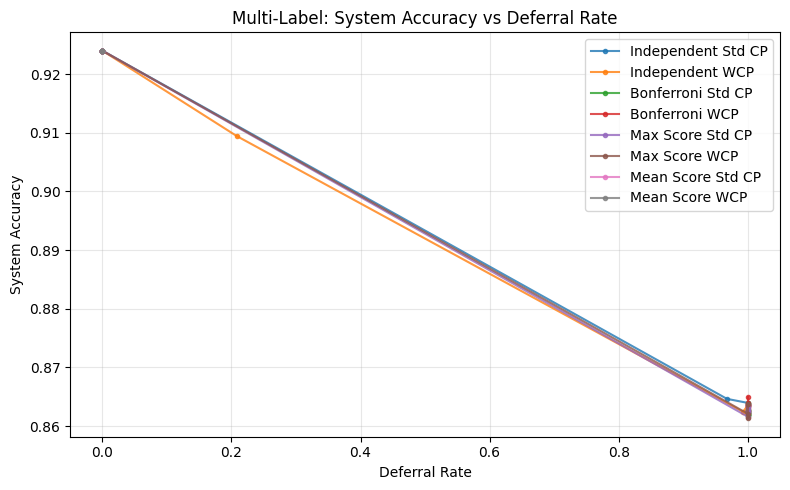

In [15]:
# Compare all strategies
fig = plot_multilabel_accuracy_rejection(
    {
        "Independent Std CP": indep_std_results,
        "Independent WCP": indep_wcp_results,
        "Bonferroni Std CP": bonf_std_results,
        "Bonferroni WCP": bonf_wcp_results,
        "Max Score Std CP": max_std_results,
        "Max Score WCP": max_wcp_results,
        "Mean Score Std CP": mean_std_results,
        "Mean Score WCP": mean_wcp_results,
    }
)
plt.show()

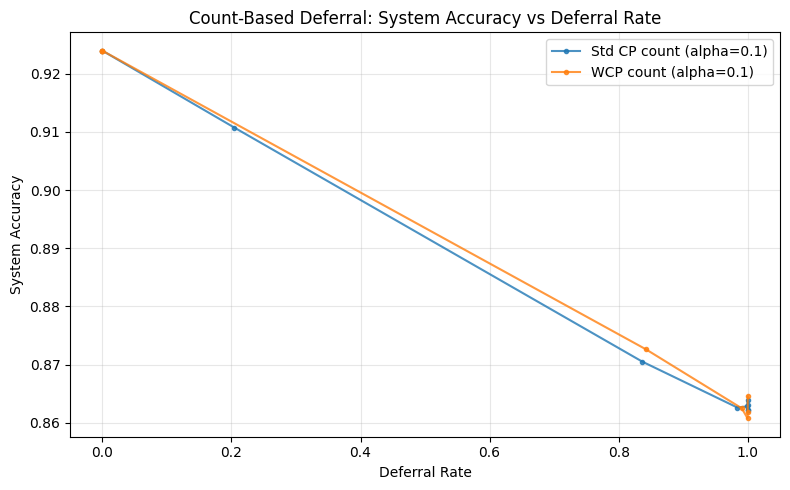

In [16]:
# Count-based deferral ARC
fig = plot_multilabel_accuracy_rejection(
    {
        f"Std CP count (alpha={alpha_fixed})": count_std_results,
        f"WCP count (alpha={alpha_fixed})": count_wcp_results,
    },
    title="Count-Based Deferral: System Accuracy vs Deferral Rate",
)
plt.show()

## 12. Coverage Comparison

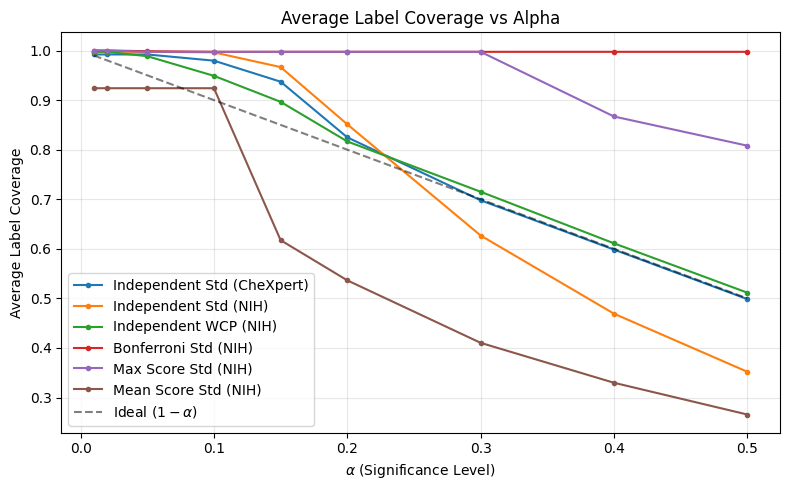

In [17]:
# Average label coverage
fig = plot_multilabel_coverage(
    {
        "Independent Std (CheXpert)": indep_std_chex_results,
        "Independent Std (NIH)": indep_std_results,
        "Independent WCP (NIH)": indep_wcp_results,
        "Bonferroni Std (NIH)": bonf_std_results,
        "Max Score Std (NIH)": max_std_results,
        "Mean Score Std (NIH)": mean_std_results,
    },
    coverage_type="average_label",
    title="Average Label Coverage vs Alpha",
)
plt.show()

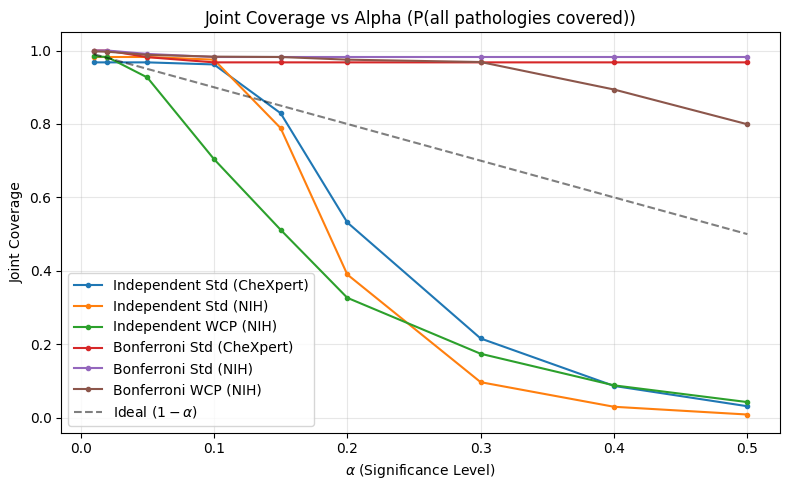

In [18]:
# Joint coverage
fig = plot_multilabel_coverage(
    {
        "Independent Std (CheXpert)": indep_std_chex_results,
        "Independent Std (NIH)": indep_std_results,
        "Independent WCP (NIH)": indep_wcp_results,
        "Bonferroni Std (CheXpert)": bonf_std_chex_results,
        "Bonferroni Std (NIH)": bonf_std_results,
        "Bonferroni WCP (NIH)": bonf_wcp_results,
    },
    coverage_type="joint",
    title="Joint Coverage vs Alpha (P(all pathologies covered))",
)
plt.show()

## 13. Per-Pathology Coverage Heatmap

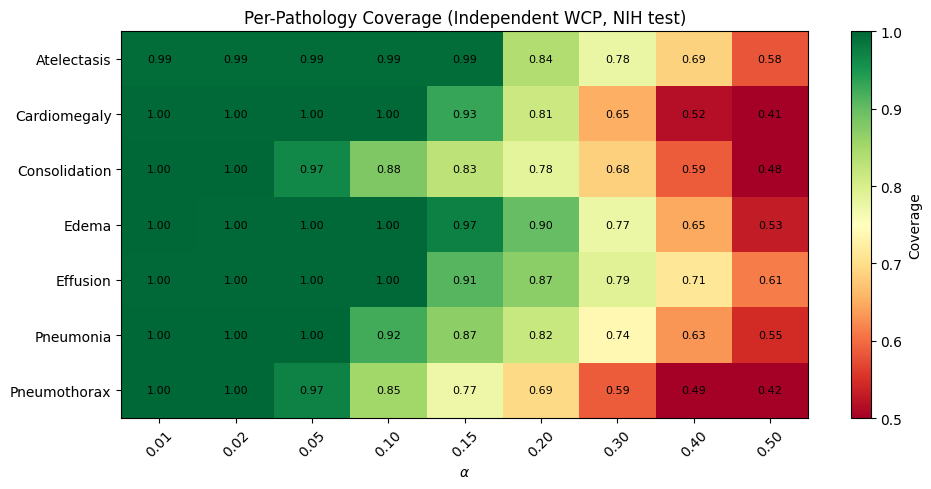

In [19]:
# Per-pathology coverage for Independent WCP (NIH)
fig = plot_per_pathology_coverage_heatmap(
    indep_wcp_results,
    COMMON_PATHOLOGIES,
    title="Per-Pathology Coverage (Independent WCP, NIH test)",
)
plt.show()

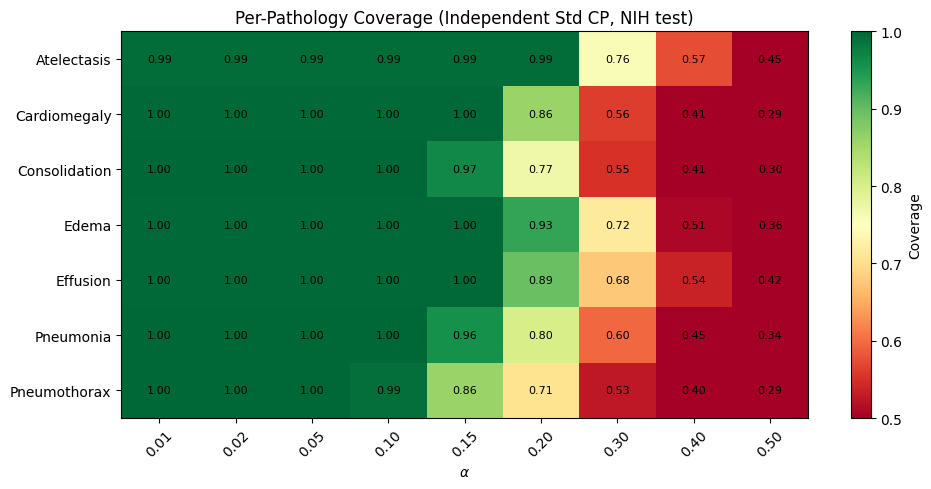

In [20]:
# Per-pathology coverage for Independent Std CP (NIH)
fig = plot_per_pathology_coverage_heatmap(
    indep_std_results,
    COMMON_PATHOLOGIES,
    title="Per-Pathology Coverage (Independent Std CP, NIH test)",
)
plt.show()

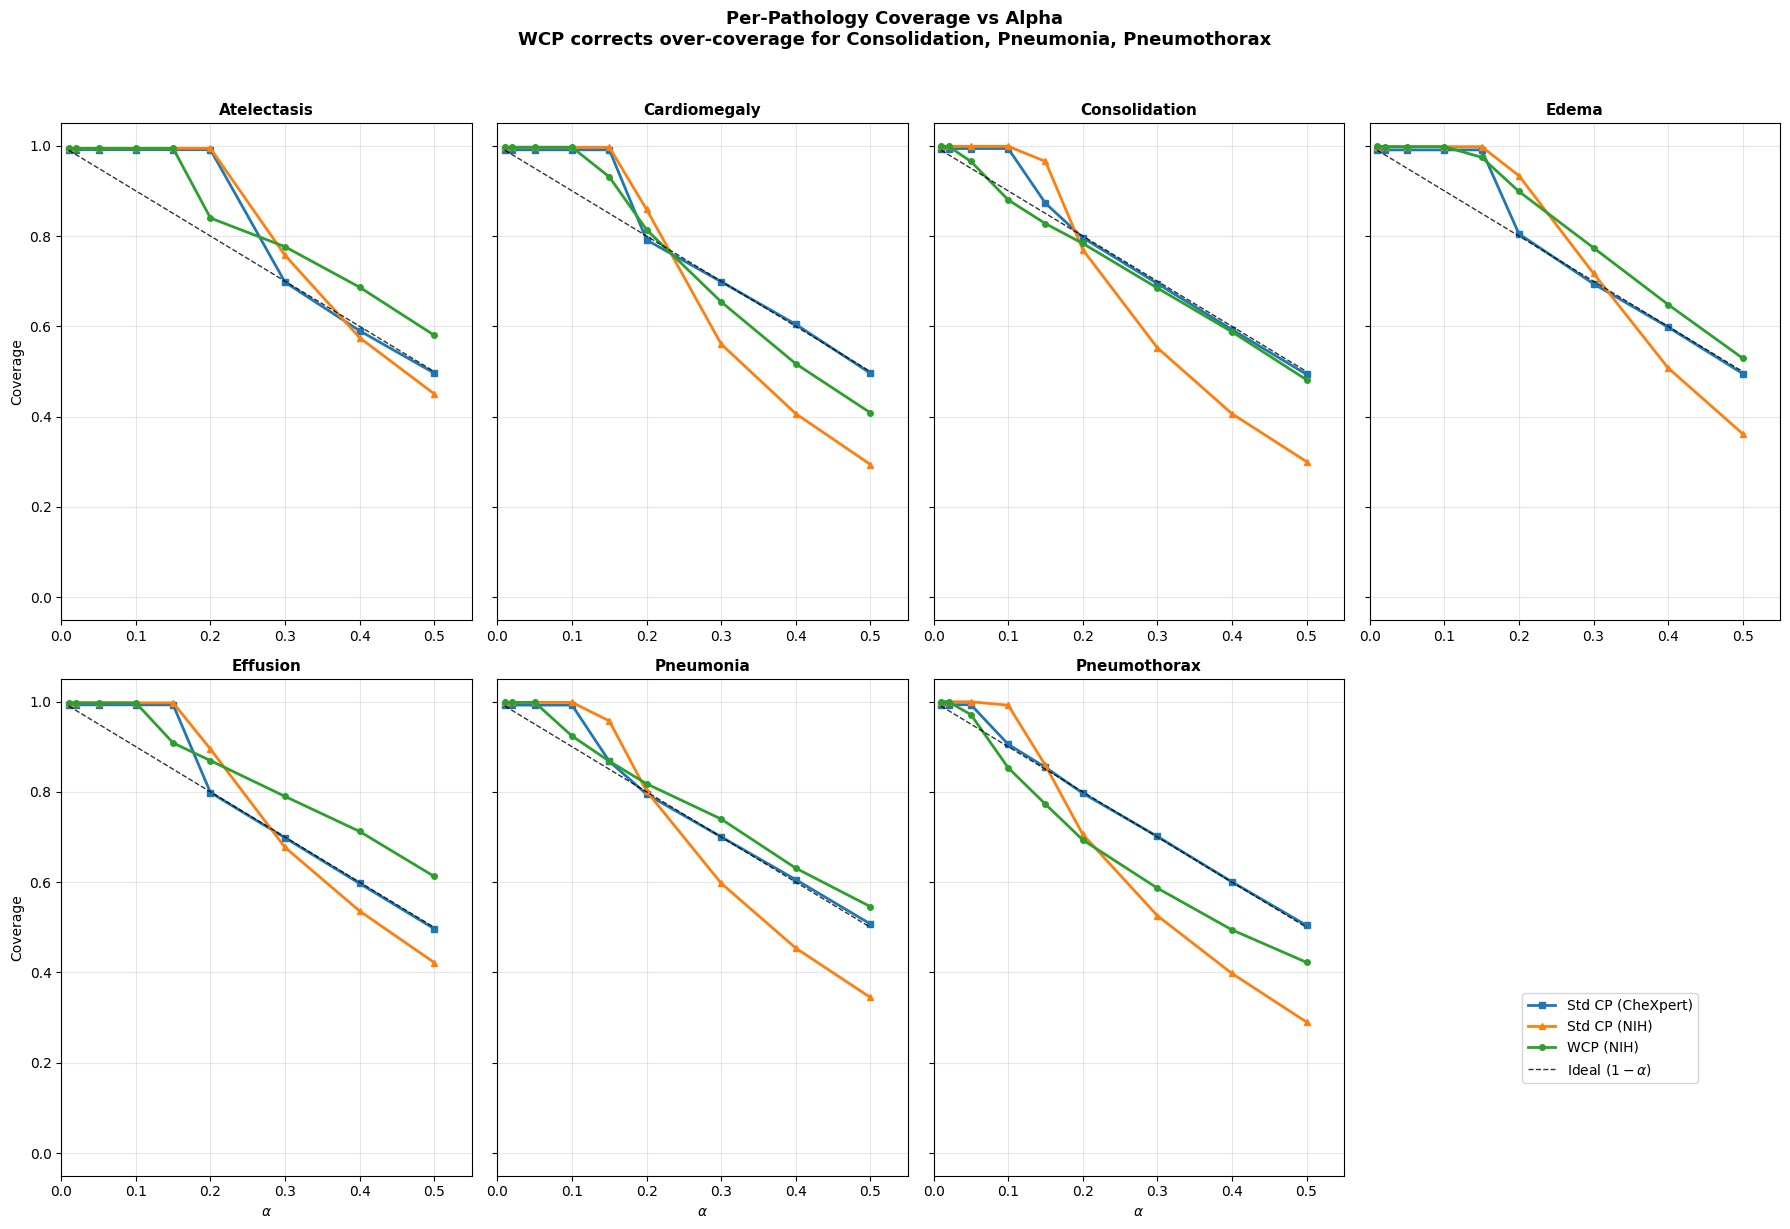

In [30]:
# Per-pathology coverage line plots: alpha vs coverage for each pathology
fig, axes = plt.subplots(2, 4, figsize=(18, 12), sharey=True)
axes_flat = axes.flatten()

for i, pathology in enumerate(COMMON_PATHOLOGIES):
    ax = axes_flat[i]

    # Extract per-pathology coverage across alphas for each method
    alphas_plot = [r.alpha_or_threshold for r in indep_std_results]
    std_cov = [
        r.per_pathology_coverage.get(pathology, np.nan) for r in indep_std_results
    ]
    wcp_cov = [
        r.per_pathology_coverage.get(pathology, np.nan) for r in indep_wcp_results
    ]
    std_chex_cov = [
        r.per_pathology_coverage.get(pathology, np.nan) for r in indep_std_chex_results
    ]

    ax.plot(
        alphas_plot,
        std_chex_cov,
        color="#1f77b4",
        linewidth=2,
        marker="s",
        markersize=4,
        label="Std CP (CheXpert)",
    )
    ax.plot(
        alphas_plot,
        std_cov,
        color="#ff7f0e",
        linewidth=2,
        marker="^",
        markersize=4,
        label="Std CP (NIH)",
    )
    ax.plot(
        alphas_plot,
        wcp_cov,
        color="#2ca02c",
        linewidth=2,
        marker="o",
        markersize=4,
        label="WCP (NIH)",
    )

    # Ideal coverage line: 1 - alpha
    ax.plot(
        alphas_plot,
        [1 - a for a in alphas_plot],
        color="black",
        linestyle="--",
        alpha=0.8,
        linewidth=1,
        label=r"Ideal ($1-\alpha$)",
    )

    ax.set_title(pathology, fontsize=11, fontweight="bold")
    ax.set_xlim(0, 0.55)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)
    if i >= 4:
        ax.set_xlabel(r"$\alpha$")
    if i % 4 == 0:
        ax.set_ylabel("Coverage")

axes_flat[7].set_visible(False)

handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower right", fontsize=10, bbox_to_anchor=(0.95, 0.12))

fig.suptitle(
    "Per-Pathology Coverage vs Alpha\n"
    "WCP corrects over-coverage for Consolidation, Pneumonia, Pneumothorax",
    fontsize=13,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

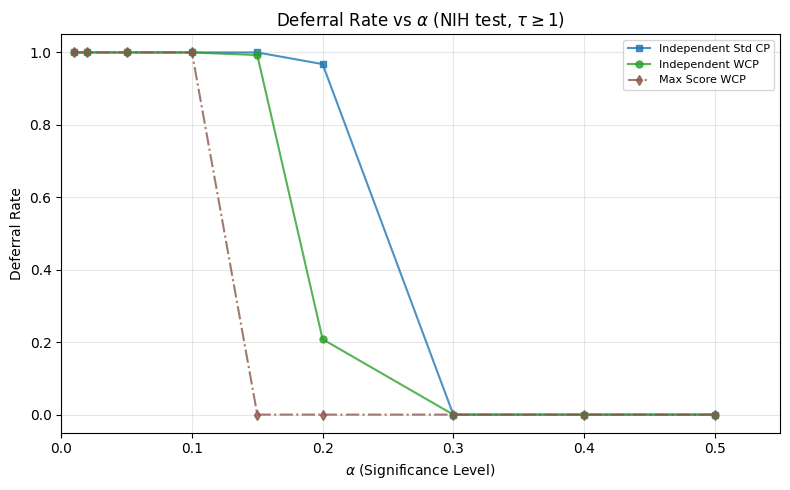

In [ ]:
# Alpha vs Deferral Rate (tau >= 1) for all aggregation strategies
fig, ax = plt.subplots(figsize=(8, 5))

methods_defer = {
    "Independent Std CP": (indep_std_results, "#1f77b4", "s", "-"),
    "Independent WCP": (indep_wcp_results, "#2ca02c", "o", "-"),
    # "Bonferroni Std CP": (bonf_std_results, "#ff7f0e", "^", "--"),
    # "Bonferroni WCP": (bonf_wcp_results, "#d62728", "v", "--"),
    # "Max Score Std CP": (max_std_results, "#9467bd", "D", "-."),
    # "Max Score WCP": (max_wcp_results, "#8c564b", "d", "-."),
    # "Mean Score Std CP": (mean_std_results, "#e377c2", "P", ":"),
    # "Mean Score WCP": (mean_wcp_results, "#7f7f7f", "X", ":"),
}

for name, (res_list, color, marker, ls) in methods_defer.items():
    a = [r.alpha_or_threshold for r in res_list]
    d = [r.deferral_rate for r in res_list]
    ax.plot(
        a,
        d,
        label=name,
        color=color,
        marker=marker,
        markersize=5,
        linestyle=ls,
        linewidth=1.5,
        alpha=0.8,
    )

ax.set_xlabel(r"$\alpha$ (Significance Level)")
ax.set_ylabel("Deferral Rate")
ax.set_title(r"Deferral Rate vs $\alpha$ (NIH test, $\tau \geq 1$)")
ax.legend(fontsize=8, loc="best")
ax.set_xlim(0, 0.55)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

## 13b. Effect of Defer Threshold (τ) on  Deferral rate

How does the deferral threshold τ (defer if ≥τ pathologies are uncertain) interact
with α for WCP? We sweep α for each τ ∈ {1, 2, ..., 7} to show:
1. α vs deferral rate — higher τ reduces deferral at any given α

In [34]:
# Sweep defer_threshold (tau) for WCP independent aggregation
tau_values = list(range(1, K + 1))  # 1 to 7

# For each tau, run WCP across all alphas
wcp_by_tau = {}
for tau in tau_values:
    wcp_by_tau[tau] = evaluate_multilabel_wcp(
        cal_logits_list,
        cal_labels,
        cal_weights,
        test_nih_logits_list,
        test_nih_labels,
        test_nih_weights,
        alphas,
        COMMON_PATHOLOGIES,
        expert,
        aggregation="independent",
        defer_threshold=tau,
    )

# Print summary table
print("WCP Independent: Alpha vs Deferral Rate for different tau values")
print(f"{'alpha':>6}", end="")
for tau in tau_values:
    print(f"  tau={tau:d}", end="")
print()
for i, alpha in enumerate(alphas):
    print(f"{alpha:>6.2f}", end="")
    for tau in tau_values:
        dr = wcp_by_tau[tau][i].deferral_rate
        print(f"  {dr:5.3f}", end="")
    print()

WCP Independent: Alpha vs Deferral Rate for different tau values
 alpha  tau=1  tau=2  tau=3  tau=4  tau=5  tau=6  tau=7
  0.01  1.000  1.000  1.000  1.000  0.999  0.979  0.790
  0.02  1.000  1.000  1.000  1.000  0.998  0.970  0.755
  0.05  1.000  1.000  1.000  0.989  0.858  0.203  0.000
  0.10  1.000  1.000  0.991  0.842  0.000  0.000  0.000
  0.15  0.993  0.786  0.113  0.000  0.000  0.000  0.000
  0.20  0.208  0.000  0.000  0.000  0.000  0.000  0.000
  0.30  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.40  0.000  0.000  0.000  0.000  0.000  0.000  0.000
  0.50  0.000  0.000  0.000  0.000  0.000  0.000  0.000


## 14. Summary Tables

In [ ]:
# Plot 1: Alpha vs Average Label Coverage for different tau
# (Coverage should be the same regardless of tau since tau only affects deferral)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(tau_values)))

ax = axes[0]
for j, tau in enumerate(tau_values):
    a = [r.alpha_or_threshold for r in wcp_by_tau[tau]]
    cov = [r.average_label_coverage for r in wcp_by_tau[tau]]
    ax.plot(
        a,
        cov,
        label=rf"$\tau={tau}$",
        color=colors[j],
        marker="o",
        markersize=4,
        linewidth=1.5,
    )

ax.plot(
    alphas,
    [1 - a for a in alphas],
    color="black",
    linestyle="--",
    alpha=0.5,
    linewidth=1.5,
    label=r"Ideal ($1-\alpha$)",
)
ax.set_xlabel(r"$\alpha$ (Significance Level)")
ax.set_ylabel("Average Label Coverage")
ax.set_title(r"WCP: $\alpha$ vs Average Label Coverage (by $\tau$)")
ax.legend(fontsize=8, loc="lower left")
ax.set_xlim(0, 0.55)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.3)

# Plot 2: Alpha vs Deferral Rate for different tau
ax = axes[1]
for j, tau in enumerate(tau_values):
    a = [r.alpha_or_threshold for r in wcp_by_tau[tau]]
    dr = [r.deferral_rate for r in wcp_by_tau[tau]]
    ax.plot(
        a,
        dr,
        label=rf"$\tau={tau}$",
        color=colors[j],
        marker="o",
        markersize=4,
        linewidth=1.5,
    )

ax.set_xlabel(r"$\alpha$ (Significance Level)")
ax.set_ylabel("Deferral Rate")
ax.set_title(r"WCP: $\alpha$ vs Deferral Rate (by $\tau$)")
ax.legend(fontsize=8, loc="upper right")
ax.set_xlim(0, 0.55)
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.3)

fig.suptitle(
    r"Effect of Defer Threshold $\tau$ on WCP (NIH test, Independent aggregation)"
    "\nHigher τ requires more uncertain pathologies to trigger deferral",
    fontsize=12,
    fontweight="bold",
    y=1.04,
)
plt.tight_layout()
plt.show()

In [21]:
# Summary at alpha=0.1
all_results = {
    "Independent Std CP": indep_std_results,
    "Independent WCP": indep_wcp_results,
    "Bonferroni Std CP": bonf_std_results,
    "Bonferroni WCP": bonf_wcp_results,
    "Max Score Std CP": max_std_results,
    "Max Score WCP": max_wcp_results,
    "Mean Score Std CP": mean_std_results,
    "Mean Score WCP": mean_wcp_results,
}

df = multilabel_summary_table(all_results, alpha=0.1)
print("\nMulti-Label CP Summary at alpha=0.1 (NIH test)")
print("=" * 90)
print(df.to_string(index=False))


Multi-Label CP Summary at alpha=0.1 (NIH test)
            Method Avg Label Cov Joint Cov Mean Uncertain Deferral System Acc Model Acc (kept)
Independent Std CP         0.996     0.975           6.02    1.000      0.862            0.000
   Independent WCP         0.949     0.704           3.83    1.000      0.862            0.000
 Bonferroni Std CP         0.997     0.982           6.72    1.000      0.862            0.000
    Bonferroni WCP         0.998     0.983           6.74    1.000      0.863            0.000
  Max Score Std CP         0.997     0.982           6.72    1.000      0.863            0.000
     Max Score WCP         0.997     0.982           6.72    1.000      0.864            0.000
 Mean Score Std CP         0.924     0.710           0.00    0.000      0.924            0.924
    Mean Score WCP         0.740     0.205           0.00    0.000      0.924            0.924


In [22]:
# Detailed per-pathology analysis at alpha=0.1 for Independent WCP
r_wcp_01 = min(indep_wcp_results, key=lambda r: abs(r.alpha_or_threshold - 0.1))
r_std_01 = min(indep_std_results, key=lambda r: abs(r.alpha_or_threshold - 0.1))

print("\nPer-pathology coverage at alpha=0.1:")
print(f"{'Pathology':<16} {'Std CP':>8} {'WCP':>8} {'Std Size':>9} {'WCP Size':>9}")
print("-" * 55)
for p in COMMON_PATHOLOGIES:
    std_cov = r_std_01.per_pathology_coverage.get(p, float("nan"))
    wcp_cov = r_wcp_01.per_pathology_coverage.get(p, float("nan"))
    std_size = r_std_01.per_pathology_set_size.get(p, float("nan"))
    wcp_size = r_wcp_01.per_pathology_set_size.get(p, float("nan"))
    print(f"{p:<16} {std_cov:>8.3f} {wcp_cov:>8.3f} {std_size:>9.3f} {wcp_size:>9.3f}")


Per-pathology coverage at alpha=0.1:
Pathology          Std CP      WCP  Std Size  WCP Size
-------------------------------------------------------
Atelectasis         0.994    0.994     1.958     1.958
Cardiomegaly        0.997    0.997     1.965     1.965
Consolidation       0.999    0.880     1.967     0.923
Edema               0.998    0.998     1.955     1.955
Effusion            0.997    0.997     1.954     1.954
Pneumonia           0.998    0.924     1.967     0.977
Pneumothorax        0.992    0.853     1.258     0.863


## 15. Comparison with Binary & Multi-Class Baselines

Reference numbers from previous experiments for context.

In [23]:
print("Comparison across all three approaches at alpha=0.1 (NIH test)")
print("=" * 80)
print()
print("1. BINARY PER-PATHOLOGY (K=2, from wcp_experiment.ipynb):")
print("   - High accuracy (AUC 0.58-0.82 on NIH)")
print("   - All-or-nothing deferral (step function)")
print("   - WCP effective: corrects over-coverage (99.6% -> 93.1% for Effusion)")
print("   - Deferral: 0-95% with no intermediate regime")
print()
print("2. MULTI-CLASS (K=7, from wcp_experiment_multiclass.ipynb):")
print("   - Low accuracy (29.3% on NIH)")
print("   - Graded deferral (set sizes 0-7)")
print("   - WCP ineffective: can't correct under-coverage (80.8%)")
print("   - Nearly 100% deferral at alpha=0.1")
print()
print("3. MULTI-LABEL (K=7 binary CPs, this notebook):")

r = min(indep_wcp_results, key=lambda r: abs(r.alpha_or_threshold - 0.1))
print(f"   - High accuracy (binary classifiers)")
print(f"   - Avg label coverage: {r.average_label_coverage:.3f}")
print(f"   - Joint coverage: {r.joint_coverage:.3f}")
print(f"   - Mean uncertain pathologies: {r.mean_uncertain_pathologies:.2f}")
print(f"   - Deferral rate (tau>=1): {r.deferral_rate:.3f}")
print(f"   - System accuracy: {r.system_accuracy:.3f}")
print()
print("Key advantage: multi-label CP combines high per-pathology accuracy")
print("with graded deferral (0-7 uncertain pathologies).")

Comparison across all three approaches at alpha=0.1 (NIH test)

1. BINARY PER-PATHOLOGY (K=2, from wcp_experiment.ipynb):
   - High accuracy (AUC 0.58-0.82 on NIH)
   - All-or-nothing deferral (step function)
   - WCP effective: corrects over-coverage (99.6% -> 93.1% for Effusion)
   - Deferral: 0-95% with no intermediate regime

2. MULTI-CLASS (K=7, from wcp_experiment_multiclass.ipynb):
   - Low accuracy (29.3% on NIH)
   - Graded deferral (set sizes 0-7)
   - WCP ineffective: can't correct under-coverage (80.8%)
   - Nearly 100% deferral at alpha=0.1

3. MULTI-LABEL (K=7 binary CPs, this notebook):
   - High accuracy (binary classifiers)
   - Avg label coverage: 0.949
   - Joint coverage: 0.704
   - Mean uncertain pathologies: 3.83
   - Deferral rate (tau>=1): 1.000
   - System accuracy: 0.862

Key advantage: multi-label CP combines high per-pathology accuracy
with graded deferral (0-7 uncertain pathologies).
